## Filtering for CRN with neural martingales

### Chemical Reaction Network setup

In [1]:
import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch
from ElenaDataManagement import count_samples_for_supersampling, get_X_Y_sampling_times, sample_trajectory_on_times, CRN_simulations_to_dataloaders, run_SSA_for_filtering

species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 151], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: mRNA # np.where(mRNA > 5, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 0.1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())

# import pandas as pd
# from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
# import numpy as np
# import matplotlib.pyplot as plt  
# from tqdm import tqdm
# import torch
# from ElenaDataManagement import count_samples_for_supersampling, get_X_Y_sampling_times, sample_trajectory_on_times, CRN_simulations_to_dataloaders, run_SSA_for_filtering

# species_names = ['M', 'P']
# stoichiometric_matrix = [[1, 0, -1, 0],
#                          [0, 1, 0, -1]]
# parameters_names = ['b1','b2', 'd1', 'd2']
# reaction_names = ['Birth Mrna', 'Birthe Protein', 'Degrade Mrna', 'Degrade Protein']
# propensities = [
#     lambda b1: b1,
#     lambda b2, M: b2*M,
#     lambda d1, M: d1*M,
#     lambda d2, P: d2*P
# ]

# range_of_species = \
#     pd.DataFrame([[0, 100], [0, 100] ], index=species_names, columns=['min', 'max'])
# range_of_parameters= \
#     pd.DataFrame([[0, 10], [0, 10], [0, 10], [0, 10]],index=parameters_names,columns=['min', 'max'])
# discretization_size_parameters = \
#     pd.DataFrame([21, 21, 21, 21], index=parameters_names) #index=parameters_names

# # The observation related information
# # h_function = [
# #     lambda Protein: Protein
# # ]
# h_function = [
#     lambda P: P # np.where(mRNA > 5, mRNA, 0)
# ]
# observation_noise_intensity = [
#     lambda : 0.1
# ]
# #observation_noise_intensity = {'sigma1': 0.1}

# maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


# MI = RBForModelIdentification(
#     species_names=species_names,
#     stoichiometric_matrix=stoichiometric_matrix,
#     parameters_names=parameters_names,
#     reaction_names=reaction_names,
#     propensities=propensities,
#     range_of_species=range_of_species,
#     range_of_parameters=range_of_parameters,
#     observation_noise_intensity=observation_noise_intensity,
#     discretization_size_parameters=discretization_size_parameters,
#     h_function=h_function,
#     maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

# print('leader species: ', MI.leader_species_time_course_data)
# print('follower species: ', MI.get_follower_species_time_course_data())
# print('follower parameters: ', MI.get_follower_parameters_time_course_data())

leader species:  ['G1']
follower species:  ['G0', 'mRNA']
follower parameters:  ['kp1', 'k2', 'k1']


setup parameters and simulate a single trajectory (just for visualization)

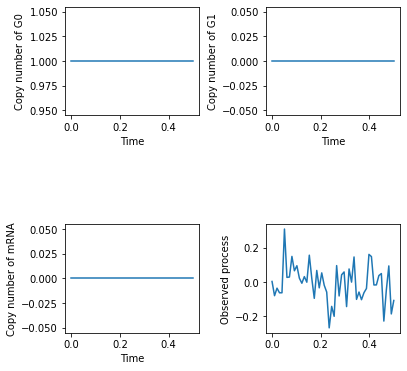

In [2]:
# Get a trajectory of the system
parameter_values_sets = []
#parameter_values_sets.append({'b1': 5, 'b2': 5, 'd1': 0.5, 'd2': 1}) # base parameters
parameter_values_sets.append({'k1': 1, 'k2': 1, 'kp1': 1})

parameter_set_index = 0
parameter_values = parameter_values_sets[parameter_set_index]
#initial_state = {'M': 0, 'P': 0}
initial_states = []
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 0})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 0})
tf = 0.5
time_list, state_list, cPP = MI.SSA(initial_states[0], parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations

Observation_times_list = np.linspace(0, tf, 50)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)

# plot the observations
plt.plot(Observation_times_list, Y_list)
plt.ylabel("Observed process")
plt.show()

visualize the centered Poisson Process

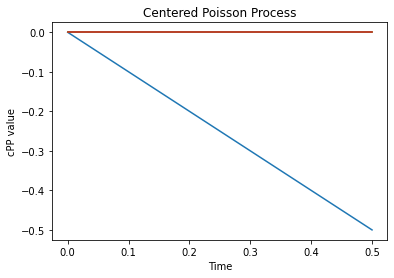

In [3]:
cPP.plot() 

In [4]:
cPP.time_list

[0.0, 0.5]

In [5]:
cPP.time_list

[0.0, 0.5]

In [6]:
cPP.sample_at_times([x for x in cPP.time_list])

array([[ 0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ]])

### Debugging information

In [7]:
cPP.time_list

[0.0, 0.5]

In [8]:
cPP.current_a

[array([1., 0., 0., 0.]), array([1., 0., 0., 0.])]

In [9]:
cPP.centered_PP_mean

[array([0., 0., 0., 0.]), array([0.5, 0. , 0. , 0. ])]

In [10]:
cPP.centered_PP

[array([0., 0., 0., 0.]), array([-0.5,  0. ,  0. ,  0. ])]

In [11]:
cPP.sample_at_times([9.99, 10., 10.01])

array([[ -9.99,   0.  ,   0.  ,   0.  ],
       [-10.  ,   0.  ,   0.  ,   0.  ],
       [-10.01,   0.  ,   0.  ,   0.  ]])

In [12]:
print(cPP.at(9.99))
print(cPP.at(10.01))

[-9.99  0.    0.    0.  ]
[-10.01   0.     0.     0.  ]


In [13]:
cPP.centered_PP_actual

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]

In [14]:
len(cPP.time_list)

2

In [15]:
np.searchsorted(np.array(cPP.time_list), 0.01, side='right') - 1

0

In [16]:
cPP.time_list

[0.0, 0.5]

In [17]:
cPP.centered_PP

[array([0., 0., 0., 0.]), array([-0.5,  0. ,  0. ,  0. ])]

In [18]:
cPP.sample_at_times([9.99, 10.01])

array([[ -9.99,   0.  ,   0.  ,   0.  ],
       [-10.01,   0.  ,   0.  ,   0.  ]])

In [19]:
cPP.at(9.99)

array([-9.99,  0.  ,  0.  ,  0.  ])

In [20]:
np.searchsorted(np.array(cPP.time_list), 9.99, side='right') - 1

1

### Dataloader structure

Let $\mathcal{T}$ be the set of measurement times, $\Tau$ the time discretization set, and $\mathcal{R}$ be the set of reactions. The dataloader should contain:

* $X(t) \forall t\in\Tau$ the full process 
* $Y(t) \forall t\in\mathcal{T}$ the observed process
* $\tilde{R}_k(t) \forall t\in\Tau, k\in \mathcal{R}$ the centered poisson process associated to the reaction $k$ 

this implies the following tensor dimensions (we condiser the batch size $B$) of the input tensors, respectively:

* $[B, |\Tau|, |X|]$
* $[B, |\mathcal{T}|, |y|]$
* $[B, |\Tau|, |r|]$


In [21]:
# this can be done quickly by running 
import math
n_samples = 1000  # p in the paper
batch_size = 200 #int(math.sqrt(n_samples))

n_Y_measurements = 2 # n in the paper
n_X_measurements_between_Y_measurements = 100 # m_bar-2 in the paper

dataset = run_SSA_for_filtering(MI, initial_states, parameter_values, tf, n_Y_measurements, n_X_measurements_between_Y_measurements, n_samples=n_samples)
train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size, test_split=0.2)

print("--- check batch sizes ---")
print("training : ", [x.shape for x in next(iter(train_dataset))])
print("validation : ", [x.shape for x in next(iter(val_dataset))])

100%|██████████| 1000/1000 [00:01<00:00, 895.46it/s]


--- check batch sizes ---
training :  [torch.Size([200, 102, 3]), torch.Size([200, 2, 1]), torch.Size([200, 102, 4])]
validation :  [torch.Size([200, 102, 3]), torch.Size([200, 2, 1]), torch.Size([200, 102, 4])]


### Reimplementing DeepCME

In [22]:
# from OtherNetworks import MLP
# from DeepCME import DeepCME, TemporalFeatureExtractor


# r = 1                          # number of temporal features
# n = MI.get_number_of_species() # number of species

# g_functions = [
#     lambda x: x[:, 0],
#     lambda x: x[:, 1],
#     #lambda x: x[:, 0]**2,
#     #lambda x: x[:, 1]**2
# ]

# R = len(g_functions)
# K = MI.get_number_of_reactions()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporal_feature_extractor = TemporalFeatureExtractor(r, tf, device=device)
# L = 2                          # number of layers
# backbone = MLP(2*r+n, L, R*K, L, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)

# tau_list = torch.linspace(0, tf, n_X_measurements_between_Y_measurements+2)

# delta_threshold = torch.tensor([])

# deepCME = DeepCME(backbone, tau_list, g_functions, temporal_feature_extractor, R, K, device=device)


In [23]:
# def deepCME_training_loop(model, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None):
#     training_loss = []
#     validation_loss = []
#     for epoch in range(n_epochs):
#         for i, (X, Y, R) in enumerate(train_loader):
#             X = X.to(model.device)
#             Y = Y.to(model.device)
#             R = R.to(model.device)
#             optimizer.zero_grad()
#             loss = model.loss(X, R)
#             loss.backward()
#             optimizer.step()
#             if scheduler is not None:
#                 scheduler.step()
#             if epoch % 10 == 0:
#                 print(f'Training: Epoch {epoch}, batch {i}, Loss {loss.item()}')
#             training_loss.append((epoch*len(train_loader) + i, loss.item()))
#         if epoch % 10 == 0 and validation_loader is not None:
#             for i, (X, Y, R) in enumerate(validation_loader):
#                 with torch.no_grad():
#                     X = X.to(model.device)
#                     Y = Y.to(model.device)
#                     R = R.to(model.device)
#                     loss = model.loss(X, R)
#                     validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
#                     if i % 10 == 0:
#                         print(f'Validation: Epoch {epoch}, batch {i}, Loss {loss.item()}')
#     return training_loss, validation_loss

# optimizer = torch.optim.Adam(deepCME.parameters(), lr=0.01)
# n_epochs = 1000
# training_loss, validation_loss = deepCME_training_loop(deepCME, train_dataset, optimizer, n_epochs, validation_loader=val_dataset)

In [24]:
# deepCME.Y

In [25]:
# raise Exception("Stop here")

### New implementation based on deepCME

In [37]:

from OtherNetworks import MLP, RNNEncoder
from DeepCME import FilteringDeepCME, TemporalFeatureExtractor


r = 1                          # number of temporal features
n = MI.get_number_of_species() # number of species
O = 1 # number of observed species

g_functions = [
    lambda x: x[:, 0],
    lambda x: x[:, 1],
    #lambda x: x[:, 0]**2,
    #lambda x: x[:, 1]**2
]

R = len(g_functions)
K = MI.get_number_of_reactions()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

temporal_feature_extractor = TemporalFeatureExtractor(r, tf, device=device)

x_hidden_size = 16
x_encoder = MLP(n, x_hidden_size, x_hidden_size, 2, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)
y_hidden_size = 16
y_encoder = RNNEncoder(O, y_hidden_size, activation=None).to(device)

L = 2                          # number of layers
backbone = MLP(2*r+x_hidden_size+y_hidden_size, L, R*K, L, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)
baseline_net = MLP(2*r+x_hidden_size+y_hidden_size, L, R, L, activation=torch.nn.ReLU, postprocessing_layer=torch.nn.Softplus()).to(device)

tau_list = torch.linspace(0, tf, n_X_measurements_between_Y_measurements+2)

# n_Y_measurements = 2 # n in the paper
# n_X_measurements_between_Y_measurements = 100 # m_bar-2 in the paper

measurement_times = torch.linspace(0, tf, n_Y_measurements)
tau_times = torch.linspace(0, tf/(n_Y_measurements-1), n_X_measurements_between_Y_measurements+2)

filteringDeepCME = FilteringDeepCME(backbone, x_encoder, y_encoder, baseline_net, tau_times, measurement_times, g_functions, temporal_feature_extractor, R, K, O, position_in_the_chain=0, n_NN_in_chain=1, device=device)

In [38]:
measurement_times

tensor([0.0000, 0.5000])

In [39]:
def deepCME_training_loop(model, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None):
    training_loss = []
    validation_loss = []
    for epoch in range(n_epochs):
        for i, (X, Y, R) in enumerate(train_loader):
            X = X.to(model.device)
            Y = Y.to(model.device)
            R = R.to(model.device)
            optimizer.zero_grad()
            loss = model.loss(X, Y, R)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            if epoch % 10 == 0:
                print(f'Training: Epoch {epoch}, batch {i}, Loss {loss.item()}')
            training_loss.append((epoch*len(train_loader) + i, loss.item()))
        if epoch % 10 == 0 and validation_loader is not None:
            for i, (X, Y, R) in enumerate(validation_loader):
                with torch.no_grad():
                    X = X.to(model.device)
                    Y = Y.to(model.device)
                    R = R.to(model.device)
                    loss = model.loss(X, Y, R)
                    validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
                    if i % 10 == 0:
                        print(f'Validation: Epoch {epoch}, batch {i}, Loss {loss.item()}')
    return training_loss, validation_loss

optimizer = torch.optim.Adam(filteringDeepCME.parameters(), lr=0.01)
n_epochs = 1000
training_loss, validation_loss = deepCME_training_loop(filteringDeepCME, train_dataset, optimizer, n_epochs, validation_loader=val_dataset)

baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[0., 1., 0.]], device='cuda:0')
)
Training: Epoch 0, batch 0, Loss 0.09055478125810623
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[1., 0., 0.]], device='cuda:0')
)
Training: Epoch 0, batch 1, Loss 0.08852016180753708
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[0., 1., 0.]], device='cuda:0')
)
Training: Epoch 0, batch 2, Loss 0.07970868051052094
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[0., 1., 0.]], device='cuda:0')
)
Training: Epoch 0, batch 3, Loss 0.07405002415180206
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[1., 0., 0.]], device='cuda:0')
)
Validation: Epoch 0, batch 0, Loss 0.06719157844781876
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[0., 1., 0.]], device='cuda:0')
)
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[1., 0., 0.]], device='cuda:0')
)
baselinex:  BatchedTensor(lvl=2, bdim=0, value=
    tensor([[1., 0., 0.]], 

KeyboardInterrupt: 

In [35]:
filteringDeepCME.eval_baseline(0., torch.tensor([[0., 1., 0.]]).to(device), torch.tensor([[[0.]]]).to(device))

tensor([[0.4647, 0.4883]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
raise Exception("Stop here")

### Neural Network setup

We omit the definition of the CRN, which is done at the beginning of the file

In [36]:
from ElenaNetworks import NeuralMartingale, NeuralMartingaleChain
from OtherNetworks import RNNEncoder, MLP

from ElenaLosses import likelihood_GaussianNoise_unbatched, likelihood_constant_one

Delta = torch.tensor(MI.stoichiometric_matrix)

# we need a version of the h_function that is efficient for torch computations (maybe?)

hx_number_of_dimensions = 1
gx_number_of_dimensions = 2

class MLP_projecting(MLP):

    def __init__(self, *argv, **kwargs):
        super(MLP_projecting, self).__init__(*argv, **kwargs)
        pass

    def forward(self, x):
        # remove the 'k related' dimensions
        return super(MLP_projecting, self).forward(x[:, 0])
    

XEncoder = MLP(MI.get_number_of_species(), 32, 32, 2, activation=torch.nn.Tanh)
YEncoder = MLP_projecting(1, 32, 32, 2, activation=torch.nn.Tanh) #RNNEncoder(len(h_function), 64, activation=torch.nn.Tanh)
backbone = MLP(1+XEncoder.output_size+YEncoder.output_size, 16, gx_number_of_dimensions, 4, postprocessing_layer=torch.nn.Softplus(), activation=torch.nn.Tanh)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NN = NeuralMartingale(
    XEncoder, YEncoder, backbone,
    likelihood_GaussianNoise_unbatched,
    {"noise_covariance": 0.1*torch.eye(hx_number_of_dimensions)}, # covariance matrix (here the identity)
    lambda x: x[2],             # h_transform
    lambda x: x[0:2],        # g_function
    torch.tensor(MI.stoichiometric_matrix).to(device), # stoichiometry matrix
    n_X_measurements_between_Y_measurements, n_Y_measurements,
    Xtimes, Ytimes,
    gx_number_of_dimensions,
    device = device,
    paired_batch_size = 10,
    batch_size = batch_size
)

NN_chain = NeuralMartingaleChain(n_Y_measurements-1, NN.to(device)).to(device)
# print model size
print("total number of parameters: ", sum(p.numel() for p in NN_chain.chain[-1].parameters() if p.requires_grad))

total number of parameters:  6322


### Training loop

now we have to define the training loop

In [80]:
def inner_training_loop(model, k, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None):
    training_loss = []
    validation_loss = []
    for epoch in range(n_epochs):
        for i, (X, Y, R) in enumerate(train_loader):
            print(i)
            X = X.to(model.device)
            Y = Y.to(model.device)
            R = R.to(model.device)
            optimizer.zero_grad()
            loss = model.chain[k].loss(X, Y, R, k)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            if i % 10 == 0:
                print(f'Training: Epoch {epoch}, batch {i}, Loss {loss.item()}')
            training_loss.append((epoch*len(train_loader) + i, loss.item()))
        print(len(train_loader))
        print(f'per epoch training loss (batch average): {sum([training_loss[epoch*len(train_loader) + x][1] for x in range(len(train_loader))])/len(train_loader)}')
        if validation_loader is not None:
            for i, (X, Y, R) in enumerate(validation_loader):
                with torch.no_grad():
                    X = X.to(model.device)
                    Y = Y.to(model.device)
                    R = R.to(model.device)
                    loss = model.chain[k].loss(X, Y, R, k)
                    validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
                    print(f'Validation: Epoch {epoch}, batch {i}, Loss {loss.item()}')
            print(f'per epoch validation loss (batch average): {sum([validation_loss[epoch*len(validation_loader) + x][1] for x in range(len(validation_loader))])/len(validation_loader)}')
    return training_loss, validation_loss
            

def outer_training_loop(model, train_loader, optimizer, n_epochs):
    for k in range(model.n_Y_measurements - 1):
        for epoch in range(n_epochs):
            for i, (X, Y, R) in enumerate(train_loader):
                
                X = X.to(model.device)
                Y = Y.to(model.device)
                R = R.to(model.device)
                optimizer.zero_grad()
                loss = model.loss(X, Y, R, k)
                loss.backward()
                optimizer.step()
                if i % 10 == 0:
                    print(f'Epoch {epoch}, Loss {loss.item()}')

optimizer = torch.optim.Adam(NN_chain.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=1.)
train_history, val_history = inner_training_loop(NN_chain, len(NN_chain.chain)-1, train_dataset, optimizer, 100, val_dataset, scheduler)

0
Training: Epoch 0, batch 0, Loss 2.005944013595581
1
2
3
4
5
per epoch training loss (batch average): 0.859007966518402
Validation: Epoch 0, batch 0, Loss 0.7401360273361206
Validation: Epoch 0, batch 1, Loss 0.4614514410495758
Validation: Epoch 0, batch 2, Loss 0.7796158194541931
Validation: Epoch 0, batch 3, Loss 0.4553094506263733
Validation: Epoch 0, batch 4, Loss 0.6632491946220398
per epoch validation loss (batch average): 0.6199523866176605
0
Training: Epoch 1, batch 0, Loss 0.5184557437896729
1
2
3
4
5
per epoch training loss (batch average): 0.5098745703697205
Validation: Epoch 1, batch 0, Loss 0.6359116435050964
Validation: Epoch 1, batch 1, Loss 0.39916789531707764
Validation: Epoch 1, batch 2, Loss 0.6391560435295105
Validation: Epoch 1, batch 3, Loss 0.1773383915424347
Validation: Epoch 1, batch 4, Loss 0.5949072241783142
per epoch validation loss (batch average): 0.4892962396144867
0
Training: Epoch 2, batch 0, Loss 0.9360252618789673
1
2
3
4
5
per epoch training loss (

In [81]:
[ x.shape for x in next(iter(val_dataset))]
# plot the training and validation loss

[torch.Size([100, 102, 3]), torch.Size([100, 2, 1]), torch.Size([100, 102, 4])]

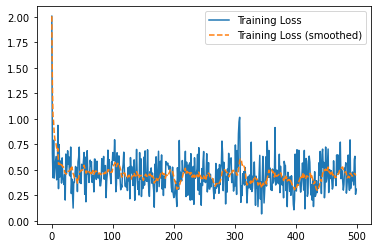

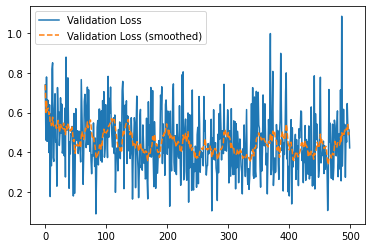

In [82]:
# plot the training and validation loss
plt.plot([x[0] for x in train_history], [x[1] for x in train_history], label='Training Loss')
# running average
plt.plot([x[0] for x in train_history], [np.mean([train_history[i][1] for i in range(max(0, x-10), x+1)]) for x in [x[0] for x in train_history]], label='Training Loss (smoothed)', linestyle='--')    
plt.legend()
plt.show()

plt.plot([x[0] for x in val_history], [x[1] for x in val_history], label='Validation Loss')
# running average
plt.plot([x[0] for x in val_history], [np.mean([val_history[i][1] for i in range(max(0, x-10), x+1)]) for x in [x[0] for x in val_history]], label='Validation Loss (smoothed)', linestyle='--')
plt.legend()
plt.show()

In [83]:
# plot the history
# # make lines thinner
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["G"])], [x.item() for x in (NN_chain.chain[-1].history["G"])], label='G', linewidth=0.5)
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["SI"])], [x.item() for x in (NN_chain.chain[-1].history["SI"])], label='SI')
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["NN"])], [x.item() for x in (NN_chain.chain[-1].history["NN"])], label='NN')
# plt.title("Sum")
# plt.legend()
# plt.show()
# # and the standard deviations
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["Gs"])], [x.item() for x in (NN_chain.chain[-1].history["Gs"])], label='G', linewidth=0.5)
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["SIs"])], [x.item() for x in (NN_chain.chain[-1].history["SIs"])], label='SI')
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["NNs"])], [x.item() for x in (NN_chain.chain[-1].history["NNs"])], label='NN')
# plt.legend()
# plt.title("Standard deviations")
# plt.show()


In [84]:
out = NN_chain.chain[-1].forward(torch.tensor(0.).cuda(), torch.tensor([[0.,1.,0.]]).cuda(), torch.tensor([[[100000.]]]).cuda())
out#/out.sum()

tensor([[0.1959, 0.1534]], device='cuda:0', grad_fn=<SoftplusBackward0>)

## Other